### Here we are goint to deal with  feature selection in our dataset 

#### how do we define the robust errorness for our model:
 we will call our ML technique robust if the following parametes are met:
        0. select the features which gives robustness
        1. The machine learning systems are consistent with properties such as invariance or robustness
        2. Even with huge training data, standard machine learning algorithms should produce predictive 
           models that make predictions inconsistent with desirable specifications like robustness or fairness
        3. for all given inputs our ML models should be able to perform invariently 

#### Analysing the data 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')



E:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_csv('data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Understaanding the data  
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.
They describe characteristics of the cell nuclei present in the image.
Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

#### whats the problem here:
1. Find out :How can we measure data error robustness for a given set of features?
2.leverage well-known feature selection strategies, such as Chi-squared ranking,to select features that are more data-error   robust
3. develop a new feature selection strategy that yields more data-error-robust representations or finds these representations faster



#### whats  my goal:
1. add/remove features required  to  make the data robust  and error proof.
2. make sure the prediction doesn't varies  even when the data is corrupted.

#### what my solution:

--------------------------------------------
final:
develop the right  feature selection strategy  to find the representations faster
-------------------------------
1. find the right  features 
2. modify the data with my  own  new calculated features if needed for robustness
3. perforn ML on those features. 
4. then , add noise to the data to make it corrupt.
5. Again perforn ML on those features
6. Repeat 1-5 to check for consistency .

In [3]:
col=data.columns
print(col)



Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [4]:
##here y = our labels  from the above data columns
#and x=our features
y = data.diagnosis                          
list = ['id','diagnosis']
x = data.drop(list,axis = 1 )
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

Number of Benign:  357
Number of Malignant :  212


In [29]:
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


 To observe all correlation between features lets plot the  heatmap 

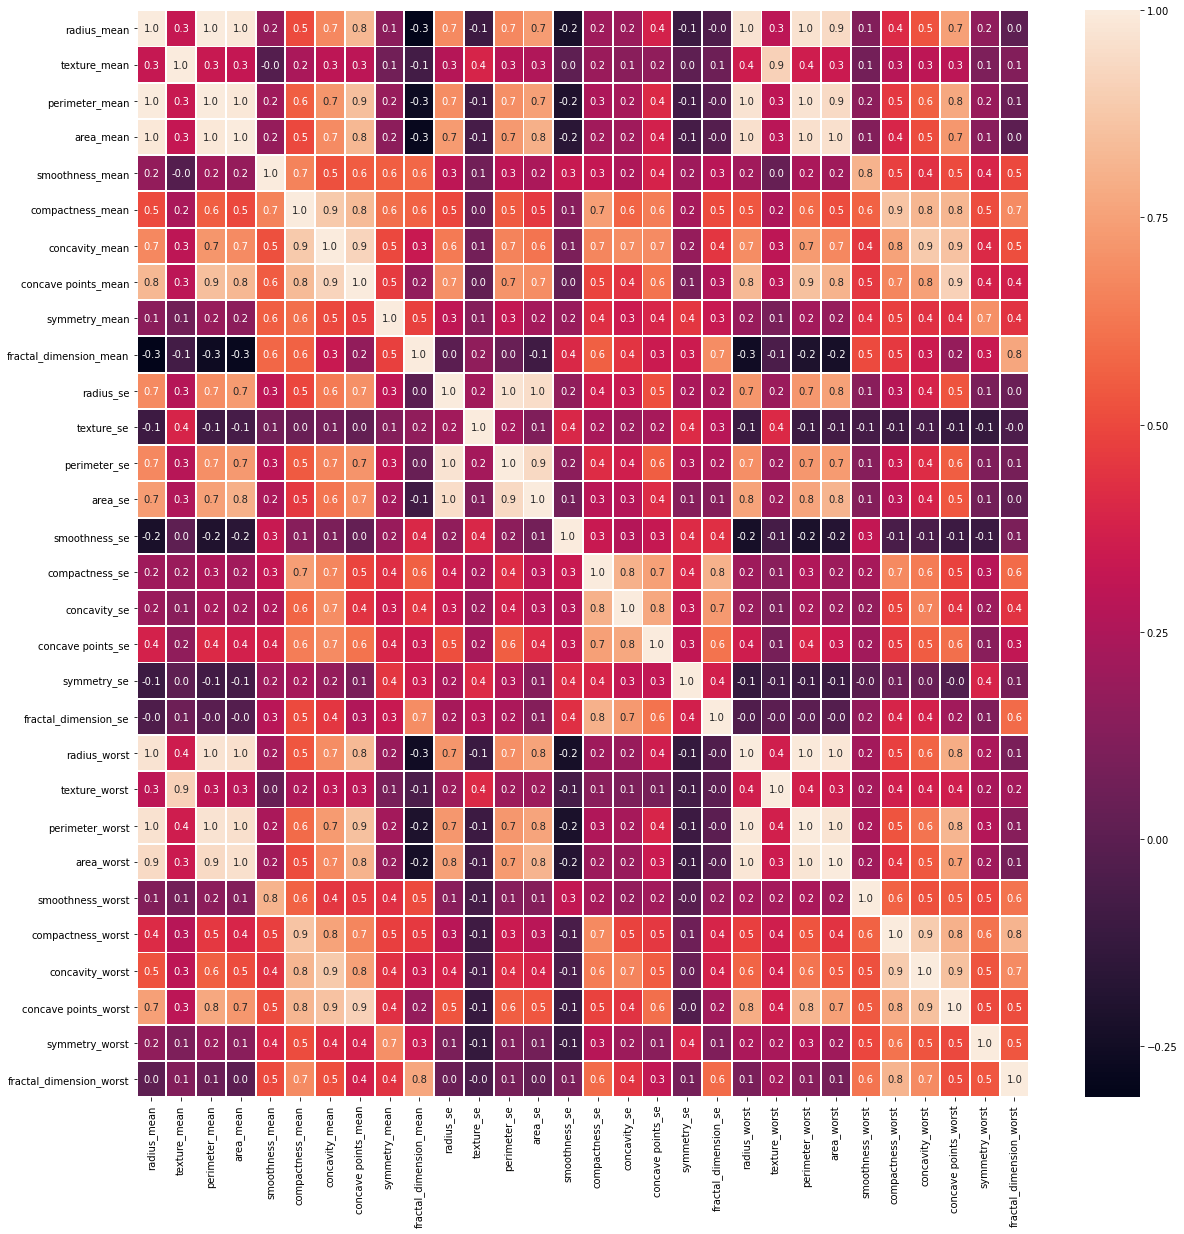

In [6]:
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(x.corr(), annot=True, linewidths=.9, fmt= '.1f',ax=ax);

Here,
1. in map heat figure radius_mean, perimeter_mean and area_mean are correlated with each other so we will use only area_mean. 
2. Compactness_mean, concavity_mean and concave points_mean are correlated with each other.Therefore I  choose concavity_mean.
3. radius_se, perimeter_se and area_se are correlated and I choose to  use area_se. 
4. radius_worst, perimeter_worst and area_worst are correlated so I choose to use area_worst. 
5. Compactness_worst, concavity_worst and concave points_worst so I choose to use concavity_worst. 
6. Compactness_se, concavity_se and concave points_se so I  choose to use concavity_se. 
7. texture_mean and texture_worst are correlated and I  choose to use texture_mean. 
8. area_worst and area_mean are correlated, I  choose to use area_mean


In [7]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave points_worst','compactness_se','concave points_se','texture_worst','area_worst']
x_1 = x.drop(drop_list1,axis = 1 ) 
x_1.head()

,texture_mean,area_mean,smoothness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,10.38,1001.0,0.11840,0.3001,0.2419,0.07871,0.9053,153.40,0.006399,0.05373,0.03003,0.006193,0.1622,0.7119,0.4601,0.11890
1,17.77,1326.0,0.08474,0.0869,0.1812,0.05667,0.7339,74.08,0.005225,0.01860,0.01389,0.003532,0.1238,0.2416,0.2750,0.08902
2,21.25,1203.0,0.10960,0.1974,0.2069,0.05999,0.7869,94.03,0.006150,0.03832,0.02250,0.004571,0.1444,0.4504,0.3613,0.08758
3,20.38,386.1,0.14250,0.2414,0.2597,0.09744,1.1560,27.23,0.009110,0.05661,0.05963,0.009208,0.2098,0.6869,0.6638,0.17300
4,14.34,1297.0,0.10030,0.1980,0.1809,0.05883,0.7813,94.44,0.011490,0.05688,0.01756,0.005115,0.1374,0.4000,0.2364,0.07678


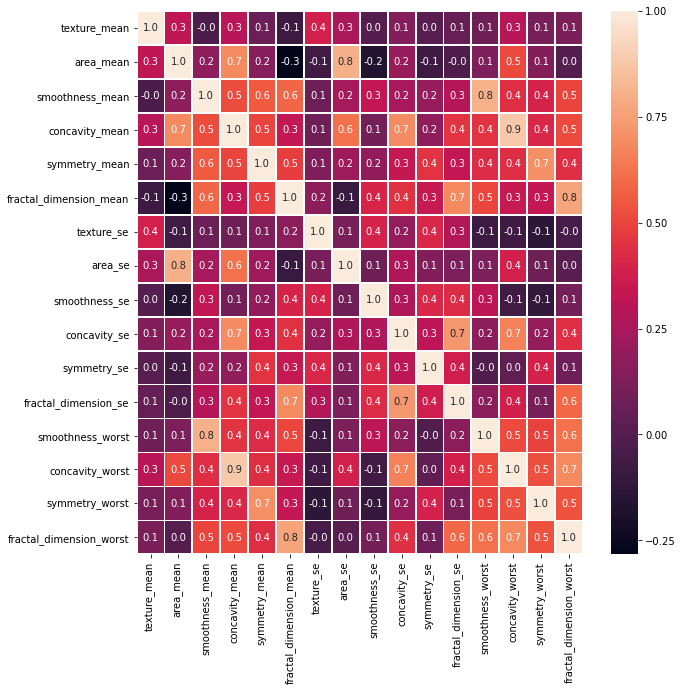

In [8]:
#new coreraltion map after dropping the features
f,ax = plt.subplots(figsize=(10, 10))

sns.heatmap(x_1.corr(), annot=True, linewidths=.9, fmt= '.1f',ax=ax);

Accuracy :  0.9532163742690059


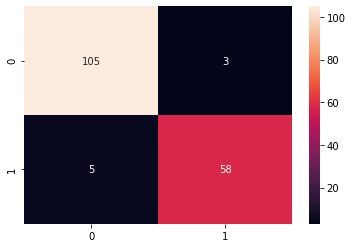

In [9]:
#lets use random forest for the above selected features 
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline


# data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x_1, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy : ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d");


## retrainig the pipeline :: to do 

In [11]:
#here in the confusion matrix we can see that there are some wrong predictions
#so we need to see other ways for feature selection 

#Lets  SelectKBest that removes all but the k highest scoring features.


In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

Score list: [6.06916433e+01 3.66899557e+04 1.00015175e-01 1.30547650e+01
 1.95982847e-01 3.42575072e-04 4.07131026e-02 6.12741067e+03
 1.32470372e-03 6.92896719e-01 1.39557806e-03 2.65927071e-03
 2.63226314e-01 2.58858117e+01 1.00635138e+00 1.23087347e-01]
Feature list: Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'area_se',
       'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')


from the above The best 5 feature to classify are:
area_mean, area_se, texture_mean, concavity_worst and concavity_mean. 
So lets see what happens if we use only these best scored 5 feature.

Accuracy :  0.9415204678362573


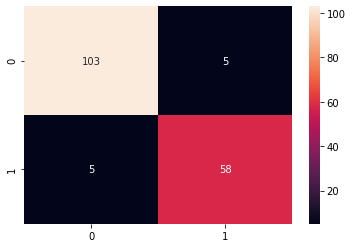

In [11]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy : ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")


So even after selecting the best 5 features in SelectkBest method the accuracy does't varies.And accuracies look similar
So , lets try RFE and  assign weights to each of features

In [12]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=10, step=1)
rfe = rfe.fit(x_train, y_train)
print('best 5 feature choosen by  rfe:',x_train.columns[rfe.support_])


best 5 feature choosen by  rfe: Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'fractal_dimension_mean', 'area_se', 'concavity_se', 'smoothness_worst',
       'concavity_worst', 'symmetry_worst'],
      dtype='object')


So, these are all same features  as in SelectKBest method  .Therefor the accuracy will be same for this as well. 
Let's try a new thing to not  only to  find best features but also how many features do we need for best accuracy.
using Recursive feature elimination with cross validation

In [40]:
from sklearn.feature_selection import RFECV

clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 10
Best features : Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'area_se', 'smoothness_se', 'concavity_se', 'fractal_dimension_se',
       'concavity_worst', 'symmetry_worst'],
      dtype='object')


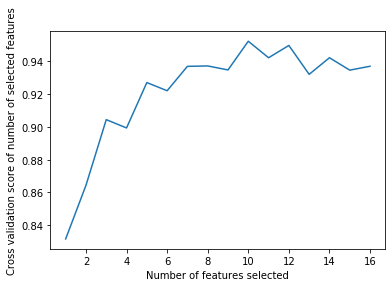

In [41]:
#accuracy plot:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

 The Feature ranking:
1. feature 3 (0.234776)
2. feature 1 (0.213382)
3. feature 13 (0.142726)
4. feature 7 (0.103252)
5. feature 0 (0.052669)
6. feature 9 (0.050939)
7. feature 12 (0.035267)
8. feature 14 (0.033529)
9. feature 15 (0.023646)
10. feature 8 (0.023259)
11. feature 11 (0.017990)
12. feature 10 (0.016960)
13. feature 5 (0.016773)
14. feature 2 (0.013510)
15. feature 4 (0.012196)
16. feature 6 (0.009125)


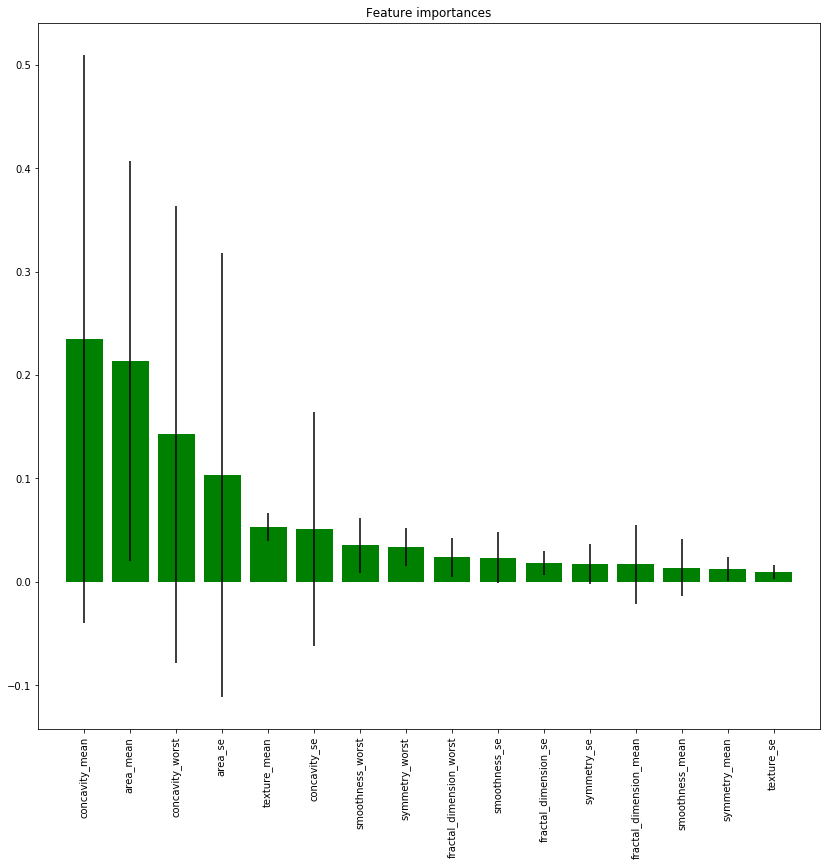

In [42]:
#implement featureimportances attributes in random forest  to see the importance of a feature 
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print(" The Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

##### scaling  the data set 

In [43]:
from scipy import stats
from mlxtend.preprocessing import minmax_scaling
np.random.seed(0)


Text(0.5, 1.0, 'Scaled data')

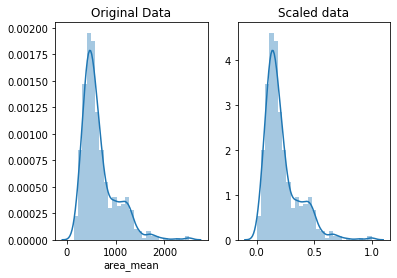

In [44]:
 
'''
as:feature choosen by  rfe: Index(['area_mean', 'concavity_mean', 'area_se', 'concavity_worst',
       'symmetry_worst'],

Also: acc to  RFECV Optimal number of features : 11
Best features : Index(['texture_mean', 'area_mean', 'concavity_mean', 'symmetry_mean',
       'area_se', 'smoothness_se', 'concavity_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst'],
      dtype='object')
      
Therefore scaling these columns:all scaling from 0 to 1

    
    =====we can scale others as well dependingon requirement======
'''

area_mean=data.area_mean
area_mean_scaled=minmax_scaling(area_mean, columns = [0])

concavity_mean=data.concavity_mean
concavity_mean_scaled=minmax_scaling(concavity_mean, columns = [0])

area_se=data.area_se
area_se_scaled=minmax_scaling(area_se, columns = [0])

concavity_worst=data.concavity_worst
concavity_worst_scaled=minmax_scaling(concavity_worst, columns = [0])

symmetry_worst=data.symmetry_worst
symmetry_worst_scaled=minmax_scaling(symmetry_worst, columns = [0])

texture_mean=data.texture_mean
texture_mean_scaled=minmax_scaling(texture_mean, columns = [0])

symmetry_mean=data.symmetry_mean
symmetry_mean_scaled=minmax_scaling(symmetry_mean, columns = [0])

smoothness_se=data.smoothness_se
smoothness_se_scaled=minmax_scaling(smoothness_se, columns = [0])

fractal_dimension_se =data.fractal_dimension_se
fractal_dimension_se_scaled=minmax_scaling(fractal_dimension_se, columns = [0])

smoothness_worst=data.smoothness_worst
smoothness_worst_scaled=minmax_scaling(smoothness_worst, columns = [0])

concavity_se=data.concavity_se
concavity_se_scaled=minmax_scaling(concavity_se, columns = [0])



#  sample plot the original & scaled data together to compare------------to check------------------
fig, ax=plt.subplots(1,2)
sns.distplot(area_mean, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(area_mean_scaled, ax=ax[1])
ax[1].set_title("Scaled data")



##############save the above scaled columns in a new csv file####################
# Scaled_data={'area_mean':area_mean_scaled,
#             'concavity_mean':concavity_mean_scaled,
#             'area_se':area_se_scaled,
#             'concavity_worst':concavity_worst_scaled,
#             'symmetry_worst':symmetry_worst_scaled,
#             'texture_mean':texture_mean_scaled,
#             'symmetry_mean':symmetry_mean_scaled,
#             'smoothness_se':smoothness_se_scaled,
#             'fractal_dimension_se':fractal_dimension_se_scaled,
#             'smoothness_worst':smoothness_worst_scaled,
#             'concavity_se':concavity_se_scaled
#             }
# df = pd.DataFrame(Scaled_data, columns= ['texture_mean', 'area_mean', 'concavity_mean', 'symmetry_mean',
#        'area_se', 'smoothness_se', 'concavity_se', 'fractal_dimension_se',
#        'smoothness_worst', 'concavity_worst', 'symmetry_worst'])
# df.to_csv (r'scaled_data.csv', header=True)


###### one hot encodeing on diagnosis


In [98]:
#pd.get_dummies(data).head()

In [45]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#values = data.diagnosis 
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)

    return(res)


encode_and_bind(data, 'diagnosis')


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_B,diagnosis_M
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0,1
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0,1
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0,1
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0,1


In [96]:

# if u want to remove the diagnosis column aftr encoding:

# def encode_and_bind(original_dataframe, feature_to_encode):
#     dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
#     res = pd.concat([original_dataframe, dummies], axis=1)
#     res = res.drop([feature_to_encode], axis=1)
#     return(res) 

# encode_and_bind(data, 'diagnosis')



#### checking for outliers in the data 

In [46]:

data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              
data = pd.concat([y,data_n_2.iloc[:,0:-1]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')


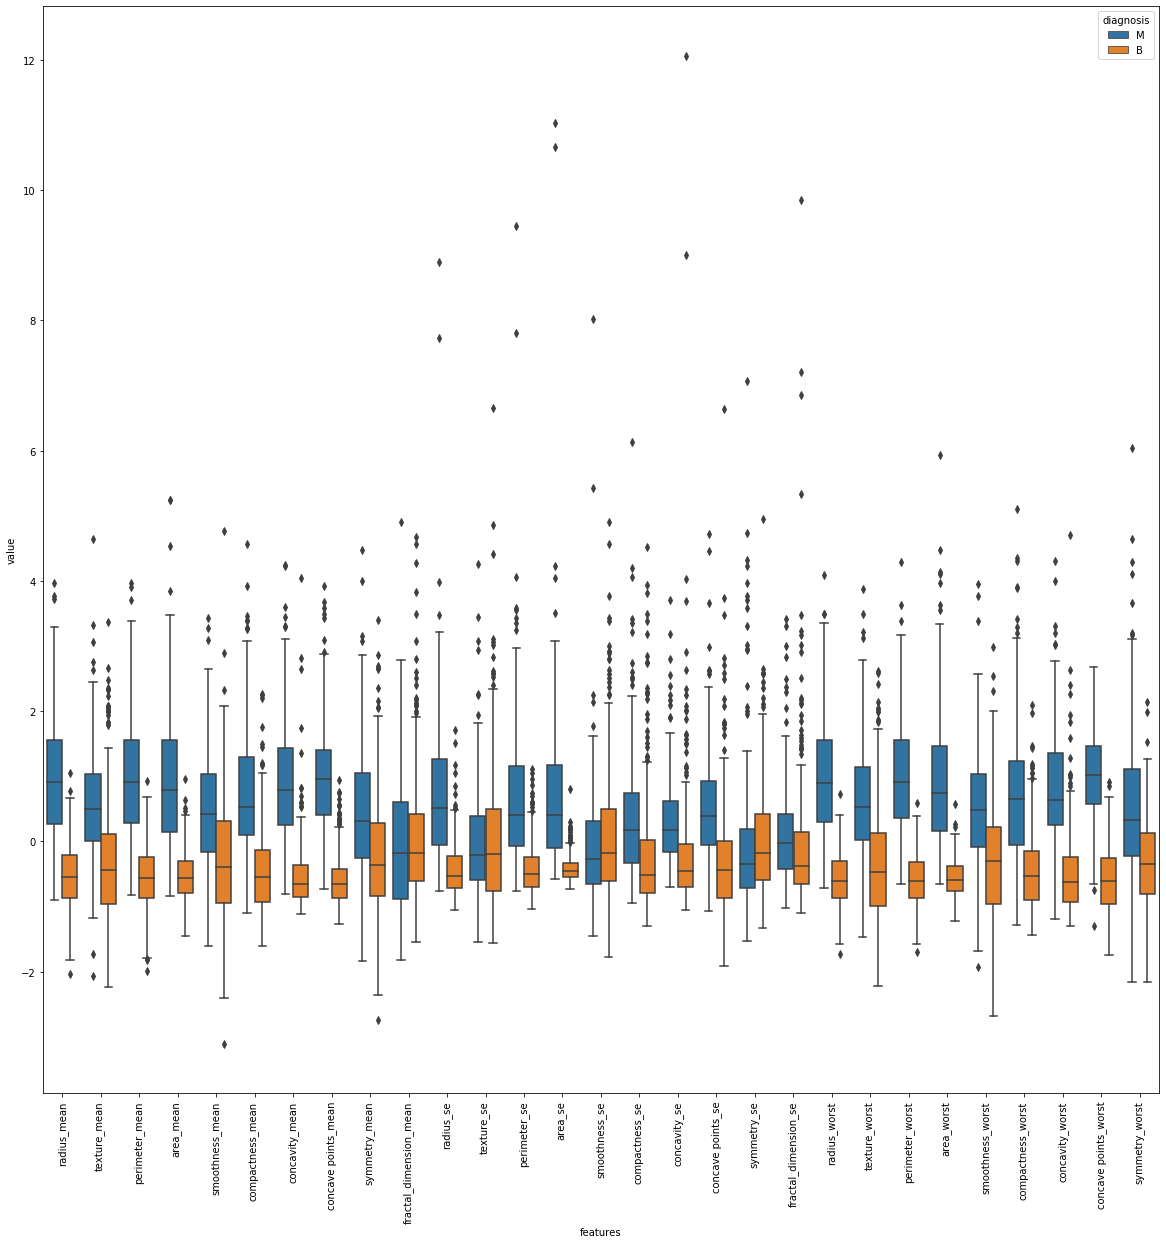

In [47]:
plt.figure(figsize=(20,20))
sns.boxplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=90);

UNIVARIATE ANALYSIS:here  we have point and these are outliers as there are not included in the box of other observation 

SO, lets do a scatter plot visualisation for multivariate analysis

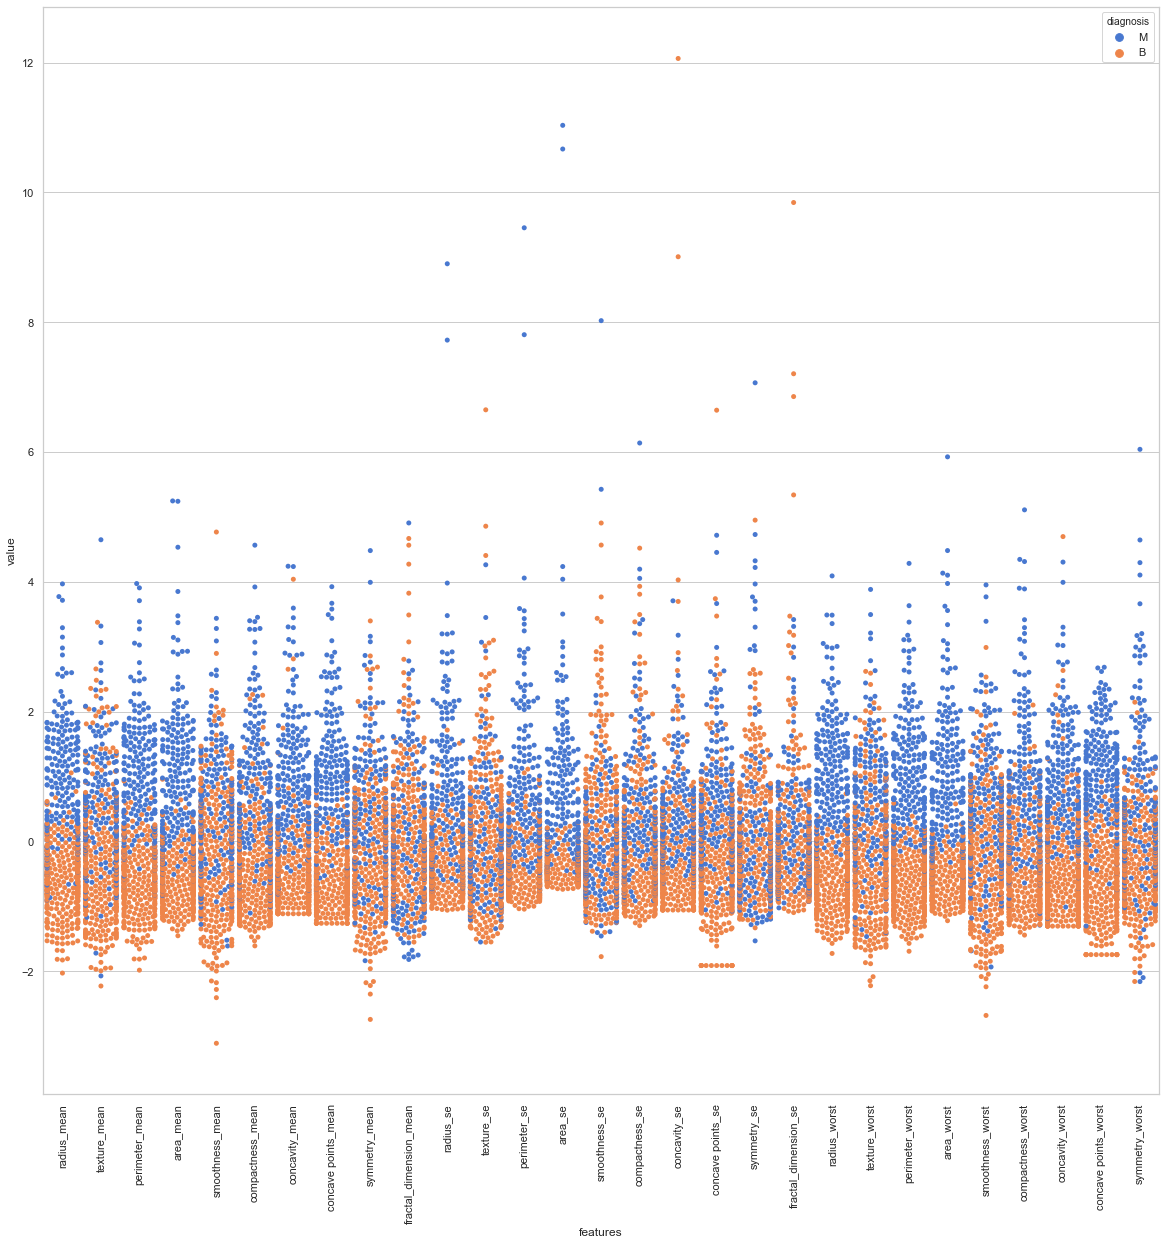

In [48]:
sns.set(style="whitegrid", palette="muted")
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              
data = pd.concat([y,data_n_2.iloc[:,0:-1]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,20))
tic = time.time()
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)

plt.xticks(rotation=90);

In [128]:
### pipelining 
### raw data in pipeline 
###  above code which i wrote will be for the reference purpose  for final comparision 
### 

In [50]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [51]:
#To implement pipeline,  we separate features and labels from the data-set at first.
X=data.drop(['diagnosis'],axis=1)
y=data['diagnosis']
X.shape,y.shape

((16501, 2), (16501,))

In [52]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = X.select_dtypes(include="number").columns.to_list()#['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = X.select_dtypes(include="object").columns.to_list()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=200))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [57]:

print("model score: %.3f" % rfc.score(X_test, y_test))

model score: 0.711


In [ ]:
### are the top feature wrt robustness are same as for accuracy !!
##we dont have a matrix yet for robustness ...---->> define a measure for that